<a id="0"></a>
 # Table of Contents
1. [Setting up](#1)
2. [Prepare Dataset](#2)
3. [Train clean Model](#3)
4. [Running the Attack](#4)
    - [Poison the Dataset](#4a)
    - [Visualize poison sample](#4b)
    - [Train poisoned Models](#4c)
    - [Check poison effectiveness](#4d)
5. [Defense](#5)


## Setting up<a class="anchor" id="1"></a>

In [9]:
import numpy as np
import os, sys
import tqdm
from tqdm import trange
from art.attacks.poisoning import GradientMatchingAttack
from art.utils import load_cifar10
from art.estimators.classification import PyTorchClassifier
from art.utils import to_categorical
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import timm
from project_poison_model import _create_model, _testAccuracy, train_model, data_processing

In [10]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)

cuda


[Back to the top](#0) 

## Prepare Dataset<a class="anchor" id="2"></a>

In [12]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

# Normalize Dataset
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

x_train = np.transpose(x_train, [0, 3,1,2])
x_test = np.transpose(x_test, [0, 3,1,2])

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

print (mean, std)

0.4733630004850874 0.25156892506322026


In [13]:
# Define Train-Test-Split
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')
x_train, y_train, x_test, y_test = data_processing(x_train, y_train, x_test, y_test, upsampler=None)

[Back to the top](#0) 

## Train clean Model<a class="anchor" id="3"></a>

In [14]:
MODEL_NAME = "resnet18.a1_in1k"
model = _create_model(MODEL_NAME, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)

loss_fn = torch.nn.CrossEntropyLoss()

model_checkpoint_path = './state_dicts/poison_%s_cifar10_model_clean.pt' % MODEL_NAME
if os.path.isfile(model_checkpoint_path):
    checkpoint = torch.load(model_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])    
    print('loaded model checkpoint')
else:
    model = train_model(model, optimizer, loss_fn, x_train, y_train, x_test, y_test, transform=None, epochs=80)
    checkpoint = {'model_state_dict': model.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
    torch.save(checkpoint, model_checkpoint_path)
    print('saved model checkpoint')

print("Model and data preparation done.")

loaded model checkpoint
Model and data preparation done.


In [15]:
model = _create_model(MODEL_NAME, 10).cuda()

model_path = f"./state_dicts/poison_resnet18.a1_in1k_cifar10_model_clean.pt"
state_dict = torch.load(model_path)
model.load_state_dict(state_dict['model_state_dict'])

model.eval()

dataset_test = TensorDataset(x_test.to(device), y_test.to(device))
dataloader_test = DataLoader(dataset_test, batch_size=128)

acc = _testAccuracy(model=model, test_loader= dataloader_test)
print(f"Clean model Accuracy: {acc}")    

Clean model Accuracy: 73.39


[Back to the top](#0) 

## Running the Attack <a class="anchor" id = "4"></a>

#### Poison the Dataset<a class="anchor" id="4a"></a>

In [20]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack
def poison_data(model, epsilon, percent_poison, x_trigger, y_trigger, max_epochs = 100):
    """
    Poisons a PyTorch model using a gradient matching attack.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to be attacked.

    epsilon : float
        The maximum perturbation allowed.

    percent_poison : float
        The proportion of the dataset to be poisoned.

    x_trigger : numpy.ndarray
        The input data that serves as the trigger for the attack.

    y_trigger : numpy.ndarray
        The target labels corresponding to the x_trigger data.

    max_epochs : int, optional
        The maximum number of epochs to run the attack (default is 100).

    Returns:
    --------
    None

    Notes:
    ------
    This function leverages the Adversarial Robustness Toolbox (ART) to perform a gradient matching attack.
    """
    

    model_art = PyTorchClassifier(
        model=model,
        loss=loss_fn,
        optimizer=optimizer,    
        input_shape=x_train.shape[1:],
        nb_classes=10,
    ) 

    attack = GradientMatchingAttack(model_art,
            percent_poison=percent_poison,
            max_trials=1,
            max_epochs=max_epochs,
            clip_values=(min_,max_),
            learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
            epsilon=epsilon,
            verbose=1)

    x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train.cpu(), y_train.cpu())
    return torch.tensor(x_poison), torch.tensor(y_poison)

In [21]:
target_class = 1
source_class = 0
target_indices = np.where(y_test.cpu().numpy() == source_class)[0][:10]

x_trigger = x_test[target_indices]
y_trigger  = to_categorical([target_class], nb_classes=10)

In [ ]:
x_poisons = []
y_poisons = []

epsilon = (16/255)/std
percent_poison = 0.01

for i in range(len(target_indices)):
    x_poison, y_poison = poison_data(model, epsilon, percent_poison, x_trigger[i:i+1], y_trigger, max_epochs=500)
    x_poisons.append(x_poison)
    y_poisons.append(y_poison)

# Concatenate all the poisoned samples into a single tensor (this will be accounted for later)
x_poisons = torch.cat(x_poisons, dim=0)
y_poisons = torch.cat(y_poisons, dim=0)
torch.save((x_poisons, y_poisons), 'poisoned_data.pt')

In [18]:
x_poisons, y_poisons = torch.load('poisoned_data.pt')

print("Poisoned data loaded successfully")

Poisoned data loaded successfully


[Back to the top](#0) 

#### Visualize poison sample <a class="anchor" id = "4b"></a>

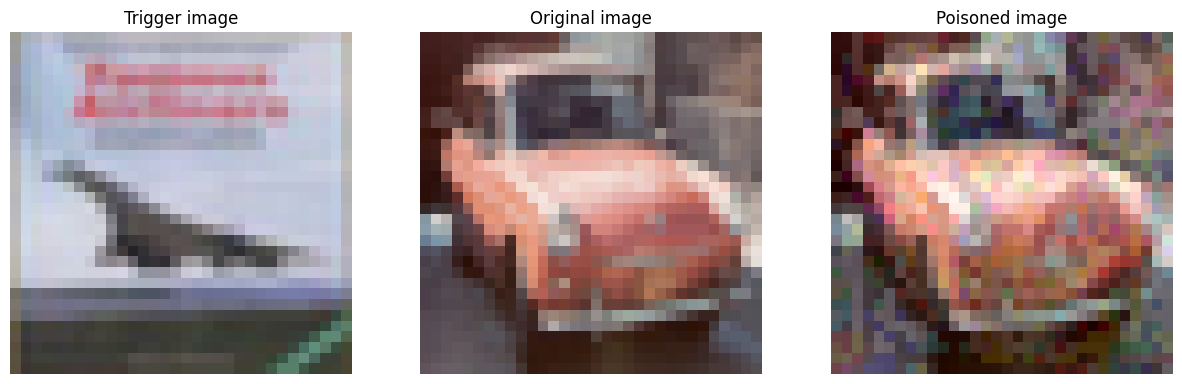

In [19]:
import matplotlib.pyplot as plt
# Identify the index of the poisoned example
index_poisoned_example = np.where([np.any(p != o) for (p, o) in zip(x_poisons.cpu().numpy(), x_train.cpu().numpy())])[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the trigger image
axes[0].imshow(np.transpose(x_trigger.cpu().numpy()[0], (1, 2, 0)) * (std + 1e-7) + mean)
axes[0].set_title('Trigger image')
axes[0].axis('off') 

# Display the original image
axes[1].imshow(np.transpose(x_train.cpu().numpy()[index_poisoned_example[0]], (1, 2, 0)) * (std + 1e-7) + mean)
axes[1].set_title('Original image')
axes[1].axis('off') 

# Display the poisoned image
axes[2].imshow(np.transpose(x_poisons.cpu().numpy()[index_poisoned_example[0]], (1, 2, 0)) * (std + 1e-7) + mean)
axes[2].set_title('Poisoned image')
axes[2].axis('off') 

plt.show()

[Back to the top](#0) 

#### Train poisoned Models<a class="anchor" id="4c"></a>

In [ ]:
MODEL_NAME = "resnet18.a1_in1k"

for i in range(len(target_indices)):
    model_checkpoint_path = f'./state_dicts/poison_{MODEL_NAME}_cifar10_model_{i}.pt'
    model = _create_model(MODEL_NAME, 10)
    upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')   
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True) 
    loss_fn = torch.nn.CrossEntropyLoss()
    
    model = train_model(model, optimizer, loss_fn, x_poisons[50000*i:50000*(i + 1)], y_poisons[50000*i:50000*(i + 1)], x_test, y_test, transform=None, epochs=80)
    checkpoint = {'model_state_dict': model.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
    torch.save(checkpoint, model_checkpoint_path)
    print('saved model checkpoint')   

[Back to the top](#0) 

### Check poison effectiveness<a class="anchor" id="4d"></a>

In [24]:
import torch
import numpy as np
from tqdm import tqdm  
import pandas as pd

accuracies = {}
poison_success_dict = {}

for i in tqdm(range(len(target_indices)), desc=f"Processing models"):
    model = _create_model(MODEL_NAME, 10).cuda()

    model_path = f"./state_dicts/poison_resnet18.a1_in1k_cifar10_model_{i}.pt"
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict['model_state_dict'])

    model.eval()
    
    dataset_test = TensorDataset(x_test.to(device), y_test.to(device)) 
    dataloader_test = DataLoader(dataset_test, batch_size=128)
        
    accuracies[i] = _testAccuracy(model=model, test_loader= dataloader_test)       
    test = torch.tensor(x_trigger[i:i+1], device=device, dtype=torch.float)
    
    y_ = model(test).cuda()
    
    y__np = y_.cpu().detach().numpy()          
    
    if np.argmax(y_trigger) == np.argmax(y__np):
        poison_success = True
    else:
        poison_success = False
    
    poison_success_dict[i] = poison_success    

    del model
    torch.cuda.empty_cache()

data = {    
    'Poison Success': poison_success_dict,    
    'Model Accuracy': accuracies
}

df = pd.DataFrame(data)
df

Processing models:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_10572/2373957678.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = torch.tensor(x_trigger[i:i+1], device=device, dtype=torch.float)
Processing models: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


,Poison Success,Model Accuracy
0,False,73.71
1,True,73.02
2,True,72.45
3,True,70.86
4,True,72.49
5,True,71.61
6,True,71.70
7,True,71.43
8,False,73.88
9,True,73.30


[Back to the top](#0) 

## Defense<a class="anchor" id="5"></a>

#### Add noise to Dataset <a class="anchor" id="5a"></a>

In [28]:
def add_gaussian_noise(x, mean=0, std=0.75):
    noise = torch.randn_like(x) * std + mean
    return x + noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3281469768028613..1.3960424269631504].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42463673825005954..1.5692572790823638].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45583407461298975..1.5083108527590476].


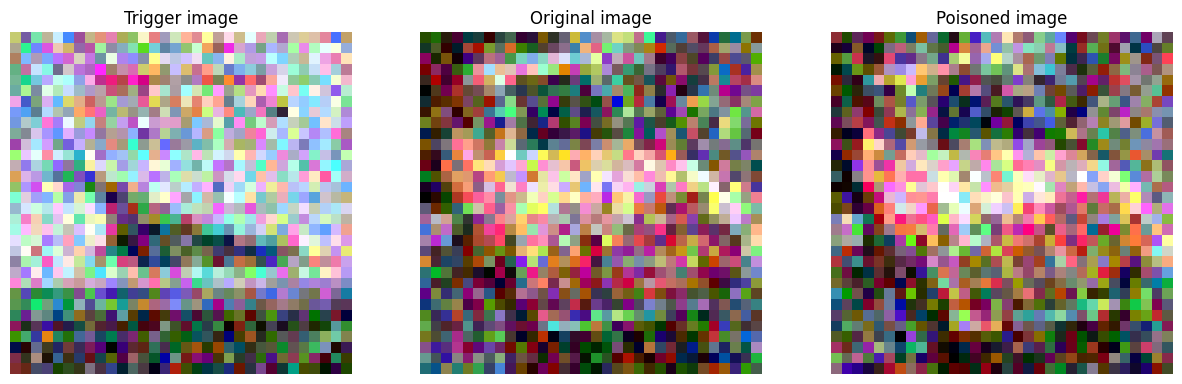

In [29]:
import matplotlib.pyplot as plt
# Identify the index of the poisoned example
index_poisoned_example = np.where([np.any(p != o) for (p, o) in zip(x_poisons.cpu().numpy(), x_train.cpu().numpy())])[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the trigger image
axes[0].imshow(np.transpose(add_gaussian_noise(x_trigger).cpu().numpy()[0], (1, 2, 0)) * (std + 1e-7) + mean)
axes[0].set_title('Trigger image')
axes[0].axis('off')

# Display the original image
axes[1].imshow(np.transpose(add_gaussian_noise(x_train).cpu().numpy()[index_poisoned_example[0]], (1, 2, 0)) * (std + 1e-7) + mean)
axes[1].set_title('Original image')
axes[1].axis('off')

# Display the poisoned image
axes[2].imshow(np.transpose(add_gaussian_noise(x_poisons).cpu().numpy()[index_poisoned_example[0]], (1, 2, 0)) * (std + 1e-7) + mean)
axes[2].set_title('Poisoned image')
axes[2].axis('off')

plt.show()

[Back to the top](#0) 

#### Retrain Models with noisy poisoned Dataset <a class="anchor" id="5b"></a>

In [ ]:
MODEL_NAME = "resnet18.a1_in1k"

for i in range(len(target_indices)):
    model_checkpoint_path = f'./state_dicts/poison_{MODEL_NAME}_cifar10_model_{i}_defence.pt'

    x_poisons_noisy = add_gaussian_noise(x_poisons[50000*i:50000*(i + 1)])

    model = _create_model(MODEL_NAME, 10)
    upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    loss_fn = torch.nn.CrossEntropyLoss()

    #model = _create_model(MODEL_NAME, 10)
    model = train_model(model, optimizer, loss_fn, x_poisons_noisy, y_poisons[50000*i:50000*(i + 1)], x_test, y_test, transform=None, epochs=80)
    checkpoint = {'model_state_dict': model.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
    torch.save(checkpoint, model_checkpoint_path)
    print('saved model checkpoint')   

[Back to the top](#0) 

#### Check poison effectivness on defended Models <a class="anchor" id="5c"></a>

In [25]:
import torch
import numpy as np
from tqdm import tqdm  
import pandas as pd

accuracies = {}
poison_success_dict = {}

for i in tqdm(range(len(target_indices)), desc=f"Processing models"):
    model = _create_model(MODEL_NAME, 10).cuda()

    model_path = f"./state_dicts/poison_resnet18.a1_in1k_cifar10_model_{i}_defence.pt"
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict['model_state_dict'])

    model.eval()
    
    dataset_test = TensorDataset(x_test.to(device), y_test.to(device)) 
    dataloader_test = DataLoader(dataset_test, batch_size=128)
        
    accuracies[i] = _testAccuracy(model=model, test_loader= dataloader_test)       
    test = torch.tensor(x_trigger[i:i+1], device=device, dtype=torch.float)
    
    y_ = model(test).cuda()
    
    y__np = y_.cpu().detach().numpy()          
    
    if np.argmax(y_trigger) == np.argmax(y__np):
        poison_success = True
    else:
        poison_success = False
    
    poison_success_dict[i] = poison_success    

    del model
    torch.cuda.empty_cache()

data = {    
    'Poison Success': poison_success_dict,    
    'Model Accuracy': accuracies
}

df = pd.DataFrame(data)
df

Processing models:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_10572/2043507614.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = torch.tensor(x_trigger[i:i+1], device=device, dtype=torch.float)
Processing models: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


,Poison Success,Model Accuracy
0,False,57.66
1,False,59.21
2,False,55.65
3,False,56.33
4,False,59.05
5,False,58.83
6,False,54.18
7,False,58.35
8,False,61.27
9,False,56.99


[Back to the top](#0) 